In [ ]:
! pip install rouge_score

### XLM - R (Full)

In [1]:
import json
import os
import torch
from tqdm import tqdm
from transformers import XLMRobertaTokenizerFast

###############################################
# 1) Hard-coded variables
###############################################
train_json = "Telugu Data/squad2.0_telugu_train.json"   # SQuAD 2.0 train
val_json   = "Telugu Data/squad2.0_telugu_val.json"     # SQuAD 2.0 val
test_json  = "Telugu Data/squad2.0_telugu_test.json"    # SQuAD 2.0 test

out_dir    = "xlm_r_processed_telugu_squad_v2"
os.makedirs(out_dir, exist_ok=True)

max_length = 512
doc_stride = 128
model_tokenizer_name = "xlm-roberta-large"  # large recommended

###############################################
# 2) Load SQuAD v2.0
###############################################
def load_squad_json(path):
    """
    Reads a SQuAD 2.0 style JSON and returns a list of QAs.
    Each QA has:
      - "id", "context", "question", 
      - "is_impossible" (bool),
      - "answers" (list),
      - "plausible_answers" (list, optional)
    """
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    examples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                ex = {
                    "id": qa["id"],
                    "context": context,
                    "question": qa["question"],
                    "is_impossible": qa.get("is_impossible", False),
                    "answers": qa.get("answers", []),
                    "plausible_answers": qa.get("plausible_answers", [])
                }
                examples.append(ex)
    return examples

###############################################
# 3) Build offset-based items
###############################################
def build_items(examples, tokenizer, max_length=384, doc_stride=128):
    """
    Build items with safe document striding.
    """
    data_list = []
    stats = {
        "total": len(examples),
        "skipped": 0,
        "chunks_created": 0
    }
    
    # Minimum sequence length to allow processing
    MIN_LENGTH = 32
    
    for ex in tqdm(examples, desc="Processing"):
        question = ex["question"]
        context = ex["context"]
        is_impossible = ex["is_impossible"]
        
        # First try without striding for shorter contexts
        try:
            enc = tokenizer(
                question,
                context,
                max_length=max_length,
                truncation="only_second",
                return_offsets_mapping=True,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Get default values
            input_ids = enc["input_ids"][0]
            attention_mask = enc["attention_mask"][0]
            offset_mapping = enc["offset_mapping"][0].tolist()
            
            # Find CLS token index
            cls_indices = (input_ids == tokenizer.cls_token_id).nonzero()
            cls_idx = cls_indices[0].item() if len(cls_indices) > 0 else 0
            
            start_idx = cls_idx
            end_idx = cls_idx
            
            # Get answer info
            gold_text = ""
            start_char = None
            end_char = None
            
            if not is_impossible and ex["answers"]:
                ans = ex["answers"][0]
                gold_text = ans["text"]
                start_char = ans["answer_start"]
                end_char = start_char + len(gold_text)
                
                # Find answer span
                if start_char is not None and end_char is not None:
                    found_start = None
                    found_end = None
                    
                    for idx, (off_start, off_end) in enumerate(offset_mapping):
                        if off_start <= start_char < off_end:
                            found_start = idx
                        if off_start < end_char <= off_end:
                            found_end = idx
                        if found_start is not None and found_end is not None:
                            break
                    
                    if (found_start is not None and 
                        found_end is not None and 
                        found_end >= found_start):
                        start_idx = found_start
                        end_idx = found_end
            
            # Create item
            item = {
                "id": ex["id"],
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "offset_mapping": offset_mapping,
                "start_positions": torch.tensor(start_idx, dtype=torch.long),
                "end_positions": torch.tensor(end_idx, dtype=torch.long),
                "context": context,
                "question": question,
                "gold_text": gold_text,
                "is_impossible": is_impossible
            }
            data_list.append(item)
            
        except Exception as e:
            # If first attempt fails, try with smaller chunks
            if len(context) > MIN_LENGTH:
                try:
                    # Split context into smaller chunks
                    chunk_size = max_length // 2  # Use half max_length for safety
                    chunks = [context[i:i+chunk_size] for i in range(0, len(context), chunk_size//2)]
                    
                    for i, chunk in enumerate(chunks):
                        try:
                            enc = tokenizer(
                                question,
                                chunk,
                                max_length=max_length,
                                truncation="only_second",
                                return_offsets_mapping=True,
                                padding="max_length",
                                return_tensors="pt"
                            )
                            
                            input_ids = enc["input_ids"][0]
                            attention_mask = enc["attention_mask"][0]
                            offset_mapping = enc["offset_mapping"][0].tolist()
                            
                            # Default to CLS for this chunk
                            cls_indices = (input_ids == tokenizer.cls_token_id).nonzero()
                            cls_idx = cls_indices[0].item() if len(cls_indices) > 0 else 0
                            
                            item = {
                                "id": f"{ex['id']}_{i}",
                                "input_ids": input_ids,
                                "attention_mask": attention_mask,
                                "offset_mapping": offset_mapping,
                                "start_positions": torch.tensor(cls_idx, dtype=torch.long),
                                "end_positions": torch.tensor(cls_idx, dtype=torch.long),
                                "context": chunk,
                                "question": question,  
                                "gold_text": "",
                                "is_impossible": True  # Mark chunks as impossible
                            }
                            data_list.append(item)
                            stats["chunks_created"] += 1
                            
                        except Exception as chunk_e:
                            continue
                            
                except Exception as chunk_e:
                    stats["skipped"] += 1
                    continue
            else:
                stats["skipped"] += 1
                continue

    print(f"\nProcessing Statistics:")
    print(f"Total examples: {stats['total']}")
    print(f"Skipped: {stats['skipped']}")
    print(f"Additional chunks created: {stats['chunks_created']}")
    print(f"Final processed items: {len(data_list)}\n")

    return data_list

###############################################
# 4) Main function
###############################################
def main():
    print("Initializing tokenizer:", model_tokenizer_name)
    tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_tokenizer_name)

    print("Loading train data from:", train_json)
    train_examples = load_squad_json(train_json)
    print("Loading val data from:", val_json)
    val_examples   = load_squad_json(val_json)

    test_examples  = []
    if os.path.exists(test_json):
        print("Loading test data from:", test_json)
        test_examples = load_squad_json(test_json)
    else:
        print("No separate test file found. Skipping test...")

    # Build items
    print("\nBuilding train items...")
    train_list = build_items(train_examples, tokenizer, max_length, doc_stride)
    print("Building val items...")
    val_list   = build_items(val_examples,   tokenizer, max_length, doc_stride)

    test_list = []
    if test_examples:
        print("Building test items...")
        test_list = build_items(test_examples, tokenizer, max_length, doc_stride)

    # Save
    train_out = os.path.join(out_dir, "train.pt")
    val_out   = os.path.join(out_dir, "val.pt")
    test_out  = os.path.join(out_dir, "test.pt")

    torch.save(train_list, train_out)
    torch.save(val_list,   val_out)
    if test_list:
        torch.save(test_list, test_out)

    print(f"\nSaved processed data to {out_dir}/:")
    print("  train.pt =>", len(train_list), "items")
    print("  val.pt   =>", len(val_list),   "items")
    if test_list:
        print("  test.pt  =>", len(test_list), "items")

    print("\nPreprocessing completed successfully!")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing tokenizer: xlm-roberta-large


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading train data from: Telugu Data/squad2.0_telugu_train.json
Loading val data from: Telugu Data/squad2.0_telugu_val.json
Loading test data from: Telugu Data/squad2.0_telugu_test.json

Building train items...


Processing: 100%|██████████| 109680/109680 [05:52<00:00, 311.13it/s]



Processing Statistics:
Total examples: 109680
Skipped: 0
Additional chunks created: 0
Final processed items: 109680

Building val items...


Processing: 100%|██████████| 8595/8595 [00:37<00:00, 230.79it/s]



Processing Statistics:
Total examples: 8595
Skipped: 0
Additional chunks created: 0
Final processed items: 8595

Building test items...


Processing: 100%|██████████| 10846/10846 [00:33<00:00, 321.63it/s]



Processing Statistics:
Total examples: 10846
Skipped: 0
Additional chunks created: 0
Final processed items: 10846


Saved processed data to xlm_r_processed_telugu_squad_v2/:
  train.pt => 109680 items
  val.pt   => 8595 items
  test.pt  => 10846 items

Preprocessing completed successfully!


Device: cuda

Loading final model from: final_xlmr_2.0_tel_3
Loading [val] data from: xlm_r_processed_telugu_squad_v2/val.pt
Running inference on val set... (num_examples=8595)

[val Metrics]:
  em: 61.30
  f1: 75.31
  bleu_unigram: 50.85
  bleu_bigram: 38.52
  rouge1: 14.86
  rouge2: 1.70
  rougeL: 14.86
  is_impossible_acc: 91.43
----------------------------------------

Performing error analysis on validation set...

Error Category Counts:
  Correct: 5269
  Partial Span: 1894
  No Overlap: 516
  Unanswerable FN: 745
  Unanswerable FP: 171

Confusion Matrix (Answerable vs. Unanswerable):
{'TP': 5855, 'FP': 171, 'FN': 745, 'TN': 1824}

Sample Misclassified Examples:

Example ID: 56be9add3aeaaa14008c9156
Question: 2011లో, బెయోన్స్ నాలుగు రాత్రులు ఎక్కడ ప్రదర్శన ఇచ్చింది? 
Gold: న్యూయార్క్ బాల్ల్యాండ్ యొక్క న్యూయార్క్
Pred: న్యూయార్క్ బాల్ల్యాండ్ యొక్క న్యూయార్క్ స్టేజ్
Error Type: Partial Span, F1: 0.67

Example ID: 56bf8fc1a10cfb1400551175
Question: ప్రధాన సింగిల్లో ఏ కళాకారుడితో యు. 

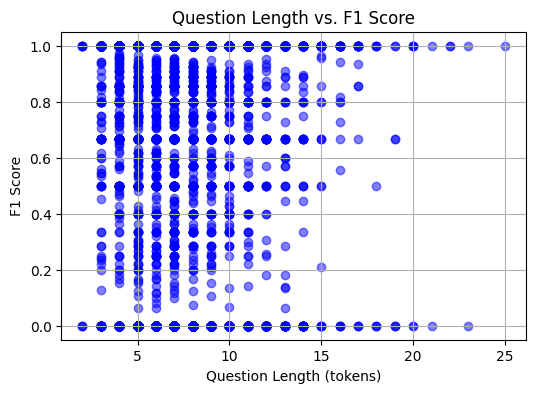

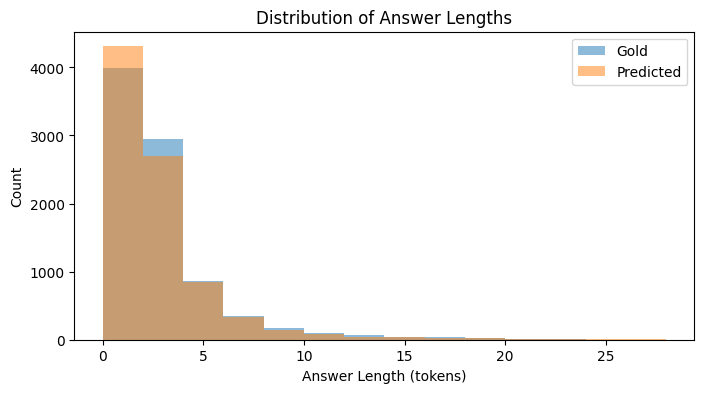

Loading [test] data from: xlm_r_processed_telugu_squad_v2/test.pt
Running inference on test set... (num_examples=10846)

[test Metrics]:
  em: 61.14
  f1: 70.65
  bleu_unigram: 27.03
  bleu_bigram: 21.40
  rouge1: 7.38
  rouge2: 0.84
  rougeL: 7.38
  is_impossible_acc: 82.20
----------------------------------------

Performing error analysis on test set...

Error Category Counts:
  Correct: 6631
  Partial Span: 1688
  Unanswerable FP: 964
  Unanswerable FN: 1024
  No Overlap: 539

Confusion Matrix (Answerable vs. Unanswerable):
{'TP': 4406, 'FP': 964, 'FN': 1024, 'TN': 4452}

Sample Misclassified Examples:

Example ID: 56ddde6b9a695914005b962c
Question: ఏ శతాబ్దంలో నార్మన్లు మొదట తమ ప్రత్యేక గుర్తింపును పొందారు? 
Gold: గుర్తింపు 10వ శతాబ్దం మొదటి భాగంలో
Pred: 10వ
Error Type: Partial Span, F1: 0.33

Example ID: 5ad39d53604f3c001a3fe8d2
Question: ఫ్రాన్స్ ఏ ప్రాంతంలో ఉంది? 
Gold: 
Pred: నార్మాండీకి
Error Type: Unanswerable FP, F1: 0.00

Example ID: 56dddf4066d3e219004dad5f
Question: హేస్

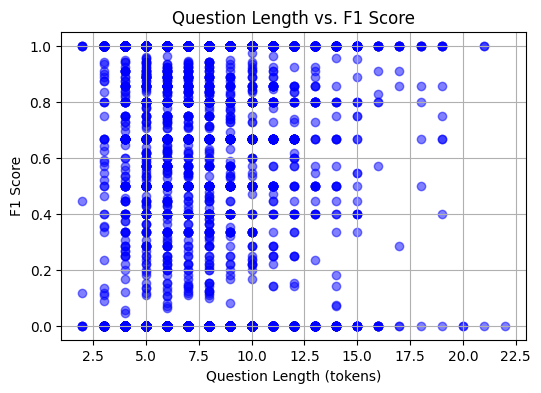

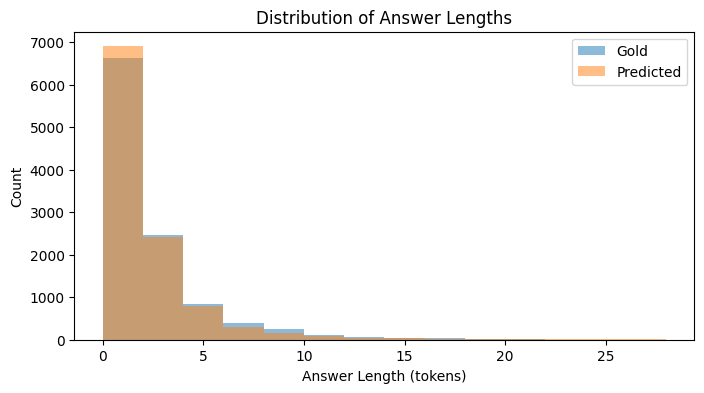


Evaluation script with error analysis completed.


In [5]:
#!/usr/bin/env python
# eval_squad_v2_telugu_with_error_analysis.py
#
# A separate evaluation script that:
#  1) Loads a fine-tuned XLM-R model (SQuAD v2.0 style).
#  2) Runs inference on val/test datasets.
#  3) Computes EM, F1, BLEU, ROUGE, plus is_impossible accuracy.
#  4) Performs comprehensive error analysis, confusion matrix, and plots.

import os
import re
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    XLMRobertaForQuestionAnswering,
    XLMRobertaTokenizerFast
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

##############################################################################
# 1) Telugu-Specific Normalization
##############################################################################
def normalize_text_telugu(s):
    """
    Minimal Telugu-oriented normalization:
      - Removes extra punctuation
      - Lowercases any English letters
      - Strips extra whitespace
    """
    if not s:
        return ""
    # Remove everything not Telugu or alphanumeric. Adjust to your corpus if needed.
    s = re.sub(r"[^\u0C00-\u0C7Fa-zA-Z0-9\s]", "", s)
    # Lowercase (affects only English letters)
    s = s.lower()
    # Remove multiple spaces
    s = " ".join(s.split())
    return s

##############################################################################
# 2) Basic Cleaning for Predicted Spans
##############################################################################
def clean_prediction(text):
    if not text:
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

##############################################################################
# 3) No-Answer Post-processing for SQuAD v2.0
##############################################################################
def postprocess_qa_predictions_squad_v2(
    examples,
    start_logits,
    end_logits,
    cls_index=0,
    max_answer_length=100,
    n_best_size=20,
    null_score_diff_threshold=0.0
):
    """
    - examples: list of dicts with "id", "context", "offset_mapping", etc.
    - start_logits[i], end_logits[i]: arrays of length [sequence_length].
    - cls_index: index for [CLS] token logit (XLM-R often has CLS at position 0).
    - null_score_diff_threshold: threshold for "no answer" decision.
    """
    preds = {}

    for i, ex in enumerate(examples):
        context = ex["context"]
        offsets = ex["offset_mapping"]
        ex_id   = ex["id"]

        # 1) Find best span
        best_score = float('-inf')
        best_start, best_end = 0, 0

        start_idxs = np.argsort(start_logits[i])[-n_best_size:].tolist()
        end_idxs   = np.argsort(end_logits[i])[-n_best_size:].tolist()

        for st in start_idxs:
            for en in end_idxs:
                if en < st:
                    continue
                if (en - st + 1) > max_answer_length:
                    continue
                if st >= len(offsets) or en >= len(offsets):
                    continue

                span_score = start_logits[i][st] + end_logits[i][en]
                if span_score > best_score:
                    best_score = span_score
                    best_start = st
                    best_end   = en

        # 2) Calculate no-answer score from [CLS] token
        cls_score = start_logits[i][cls_index] + end_logits[i][cls_index]

        # 3) Decide if no-answer
        score_diff = best_score - cls_score
        if score_diff < null_score_diff_threshold:
            preds[ex_id] = ""
        else:
            start_char = offsets[best_start][0]
            end_char   = offsets[best_end][1]
            text_span  = context[start_char:end_char]
            preds[ex_id] = clean_prediction(text_span)

    return preds

##############################################################################
# 4) Metrics: EM, F1, BLEU, ROUGE, plus is_impossible accuracy
##############################################################################
def exact_match(pred, gold):
    return 1.0 if normalize_text_telugu(pred) == normalize_text_telugu(gold) else 0.0

def f1_score(pred, gold):
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return float(pred_tokens == gold_tokens)
    precision = num_same / len(pred_tokens)
    recall    = num_same / len(gold_tokens)
    if (precision + recall) == 0:
        return 0.0
    return (2.0 * precision * recall) / (precision + recall)

def compute_bleu(pred, gold):
    if not pred or not gold:
        return {"unigram": 0.0, "bigram": 0.0}
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    smoothing = SmoothingFunction().method1
    unigram = sentence_bleu([gold_tokens], pred_tokens,
                            weights=(1, 0, 0, 0),
                            smoothing_function=smoothing)
    bigram  = sentence_bleu([gold_tokens], pred_tokens,
                            weights=(0.5, 0.5, 0, 0),
                            smoothing_function=smoothing)
    return {"unigram": unigram, "bigram": bigram}

def compute_rouge(pred, gold):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=False)
    if not pred or not gold:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    pred_clean = normalize_text_telugu(pred)
    gold_clean = normalize_text_telugu(gold)
    scores = scorer.score(pred_clean, gold_clean)
    return {
        "rouge1": scores["rouge1"].fmeasure,
        "rouge2": scores["rouge2"].fmeasure,
        "rougeL": scores["rougeL"].fmeasure
    }

def compute_is_impossible_accuracy(examples, predictions):
    """
    For each example, if gold_text is empty => gold is_impossible.
    We check if predicted text is also empty => predicted is_impossible.
    Then compute accuracy over *only* the is_impossible subset.
    """
    total_impossible = 0
    correct_impossible = 0
    for ex in examples:
        gold = ex.get("gold_text", "")
        gold_impossible = (gold.strip() == "")
        if gold_impossible:
            total_impossible += 1
            pred_text = predictions.get(ex["id"], "")
            if pred_text.strip() == "":
                correct_impossible += 1

    if total_impossible == 0:
        return 100.0  # If no impossible examples exist, define as 100% or 0%
    return (correct_impossible / total_impossible) * 100.0

##############################################################################
# 5) Master Evaluation Function
##############################################################################
def evaluate_squad_v2(examples, start_logits, end_logits, null_score_diff_threshold=0.0):
    """
    Returns a dict with EM, F1, BLEU, ROUGE, plus 'is_impossible_acc'.
    Also returns the raw predictions for further analysis.
    """
    predictions = postprocess_qa_predictions_squad_v2(
        examples,
        start_logits,
        end_logits,
        cls_index=0,  # For xlm-roberta, typically 0 is [CLS]
        null_score_diff_threshold=null_score_diff_threshold
    )

    total = len(examples)
    metrics = {
        "em": 0.0,
        "f1": 0.0,
        "bleu_unigram": 0.0,
        "bleu_bigram": 0.0,
        "rouge1": 0.0,
        "rouge2": 0.0,
        "rougeL": 0.0
    }

    for ex in examples:
        gold = ex.get("gold_text", "")
        pred = predictions.get(ex["id"], "")

        metrics["em"] += exact_match(pred, gold)
        metrics["f1"] += f1_score(pred, gold)

        bleu_scores = compute_bleu(pred, gold)
        metrics["bleu_unigram"] += bleu_scores["unigram"]
        metrics["bleu_bigram"]  += bleu_scores["bigram"]

        rouge_scores = compute_rouge(pred, gold)
        metrics["rouge1"] += rouge_scores["rouge1"]
        metrics["rouge2"] += rouge_scores["rouge2"]
        metrics["rougeL"] += rouge_scores["rougeL"]

    # Average the main metrics
    for key in metrics:
        metrics[key] = (metrics[key] / total) * 100.0

    # Calculate is_impossible accuracy
    is_imp_acc = compute_is_impossible_accuracy(examples, predictions)
    metrics["is_impossible_acc"] = is_imp_acc

    return metrics, predictions

##############################################################################
# 6) Minimal Collate for Eval
##############################################################################
def squad_collate_eval(features):
    """
    For evaluation, we only need input_ids & attention_mask for the model.
    Convert lists to Tensors.
    """
    input_ids = []
    attention_masks = []
    for f in features:
        input_ids.append(torch.tensor(f["input_ids"], dtype=torch.long))
        attention_masks.append(torch.tensor(f["attention_mask"], dtype=torch.long))
    return {
        "input_ids": torch.stack(input_ids, dim=0),
        "attention_mask": torch.stack(attention_masks, dim=0)
    }

##############################################################################
# 7) Error Analysis Utilities
##############################################################################
def categorize_errors(example, pred_text):
    """
    Returns a string category label for the error type:
      - "Correct" if EM = 1.0
      - "Partial Span" if F1 > 0 but < 1
      - "Unanswerable FP" if gold is empty but prediction is not
      - "Unanswerable FN" if gold is not empty but prediction is empty
      - "No Overlap" if F1 == 0 (and not unanswerable mismatch)
    """
    gold_text = example.get("gold_text", "")
    pred_text = pred_text.strip()
    em_val = exact_match(pred_text, gold_text)
    f1_val = f1_score(pred_text, gold_text)

    gold_empty = (gold_text.strip() == "")
    pred_empty = (pred_text == "")

    if em_val == 1.0:
        return "Correct"
    if gold_empty and not pred_empty:
        return "Unanswerable FP"  # Model predicted answer, but gold says no-answer
    if not gold_empty and pred_empty:
        return "Unanswerable FN"  # Gold answer exists, but model says no-answer
    if f1_val > 0 and f1_val < 1.0:
        return "Partial Span"
    if f1_val == 0:
        return "No Overlap"
    return "Other"

def build_confusion_matrix_error_types(df):
    """
    Builds a confusion matrix specifically for answerable vs. unanswerable.
    df must have columns: [gold_text, pred_text].
    We'll define:
        gold_answerable = gold_text != ""
        pred_answerable = pred_text != ""
    Returns a dict with {TP, FP, FN, TN}.
    """
    tp = fp = fn = tn = 0
    for idx, row in df.iterrows():
        gold_is_ans = (row["gold_text"].strip() != "")
        pred_is_ans = (row["pred_text"].strip() != "")

        if gold_is_ans and pred_is_ans:
            tp += 1
        elif not gold_is_ans and pred_is_ans:
            fp += 1
        elif gold_is_ans and not pred_is_ans:
            fn += 1
        else:
            tn += 1
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

##############################################################################
# 8) Main Error Analysis Function
##############################################################################
def perform_error_analysis(data_list, predictions, do_plots=True, show_samples=5):
    """
    data_list: list of examples with fields ["id", "question", "gold_text", "context", ...]
    predictions: dict of {example_id: predicted_answer_text}
    do_plots: if True, generate example plots (requires matplotlib).
    show_samples: how many misclassified examples to print out.

    Returns a DataFrame with error type, F1, etc. and performs optional plots.
    """
    import pandas as pd

    # Build a DataFrame of predictions vs. gold
    rows = []
    for ex in data_list:
        ex_id = ex["id"]
        question = ex.get("question", "")
        gold_text = ex.get("gold_text", "")
        context   = ex.get("context", "")
        pred_text = predictions.get(ex_id, "")

        # Compute error metrics
        em_val  = exact_match(pred_text, gold_text)
        f1_val  = f1_score(pred_text, gold_text)
        error_t = categorize_errors(ex, pred_text)

        rows.append({
            "id": ex_id,
            "question": question,
            "gold_text": gold_text,
            "pred_text": pred_text,
            "f1": f1_val,
            "em": em_val,
            "error_type": error_t,
            "context": context
        })

    df = pd.DataFrame(rows)

    # Quick summary of error categories
    error_counts = Counter(df["error_type"])
    print("\nError Category Counts:")
    for k, v in error_counts.items():
        print(f"  {k}: {v}")

    # Confusion Matrix for Answerable vs. Unanswerable
    cm = build_confusion_matrix_error_types(df)
    print("\nConfusion Matrix (Answerable vs. Unanswerable):")
    print(cm)

    # Optionally show some misclassified examples
    if show_samples > 0:
        print("\nSample Misclassified Examples:")
        misclassified_df = df[df["error_type"] != "Correct"]
        for i in range(min(show_samples, len(misclassified_df))):
            row = misclassified_df.iloc[i]
            print(f"\nExample ID: {row['id']}")
            print(f"Question: {row['question']}")
            print(f"Gold: {row['gold_text']}")
            print(f"Pred: {row['pred_text']}")
            print(f"Error Type: {row['error_type']}, F1: {row['f1']:.2f}")

    # Generate plots if requested
    if do_plots:
        # 1) Question Length vs. F1
        df["q_len"] = df["question"].apply(lambda x: len(x.split()))
        plt.figure(figsize=(6,4))
        plt.scatter(df["q_len"], df["f1"], alpha=0.5, c='blue')
        plt.title("Question Length vs. F1 Score")
        plt.xlabel("Question Length (tokens)")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.show()

        # 2) Distribution of Answer Lengths (Gold vs. Pred)
        df["gold_len"] = df["gold_text"].apply(lambda x: len(normalize_text_telugu(x).split()))
        df["pred_len"] = df["pred_text"].apply(lambda x: len(normalize_text_telugu(x).split()))

        plt.figure(figsize=(8,4))
        plt.hist(df["gold_len"], bins=range(0, 30, 2), alpha=0.5, label="Gold")
        plt.hist(df["pred_len"], bins=range(0, 30, 2), alpha=0.5, label="Predicted")
        plt.title("Distribution of Answer Lengths")
        plt.xlabel("Answer Length (tokens)")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

    return df

##############################################################################
# 9) Main Evaluation Code with Error Analysis
##############################################################################
def main():

    DATA_DIR = "xlm_r_processed_telugu_squad_v2"

    # Adjust these paths:
    MODEL_DIR = "final_xlmr_2.0_tel_3"
    VAL_FILE  = os.path.join(DATA_DIR, "val.pt")
    TEST_FILE = os.path.join(DATA_DIR, "test.pt")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Load model
    print("\nLoading final model from:", MODEL_DIR)
    model = XLMRobertaForQuestionAnswering.from_pretrained(MODEL_DIR)
    model.eval()
    model.to(device)

    # Optional: load tokenizer if needed for additional processing
    tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large")

    def run_eval(data_file, split_name="val"):
        if not os.path.exists(data_file):
            print(f"[{split_name}] file not found: {data_file}")
            return None, None
        print(f"Loading [{split_name}] data from:", data_file)
        data_list = torch.load(data_file)
        dataset = Dataset.from_list(data_list)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=squad_collate_eval)

        all_start_logits = []
        all_end_logits   = []

        print(f"Running inference on {split_name} set... (num_examples={len(dataset)})")
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                start_logits = outputs.start_logits.detach().cpu().numpy()
                end_logits   = outputs.end_logits.detach().cpu().numpy()

                all_start_logits.append(start_logits)
                all_end_logits.append(end_logits)

        all_start_logits = np.concatenate(all_start_logits, axis=0)
        all_end_logits   = np.concatenate(all_end_logits, axis=0)

        # Evaluate with threshold=0.0 (typical default)
        results, preds = evaluate_squad_v2(
            data_list,
            all_start_logits,
            all_end_logits,
            null_score_diff_threshold=0.0
        )
        print(f"\n[{split_name} Metrics]:")
        for k, v in results.items():
            print(f"  {k}: {v:.2f}")
        print("-"*40)

        return results, (data_list, preds)

    # Evaluate on validation
    val_metrics, val_data = run_eval(VAL_FILE, "val")
    if val_data is not None:
        val_list, val_preds = val_data
        # Perform error analysis on the validation set
        print("\nPerforming error analysis on validation set...")
        df_val_errors = perform_error_analysis(val_list, val_preds, do_plots=True, show_samples=5)

    # Evaluate on test
    test_metrics, test_data = run_eval(TEST_FILE, "test")
    if test_data is not None:
        test_list, test_preds = test_data
        print("\nPerforming error analysis on test set...")
        df_test_errors = perform_error_analysis(test_list, test_preds, do_plots=True, show_samples=5)

    print("\nEvaluation script with error analysis completed.")

if __name__ == "__main__":
    main()

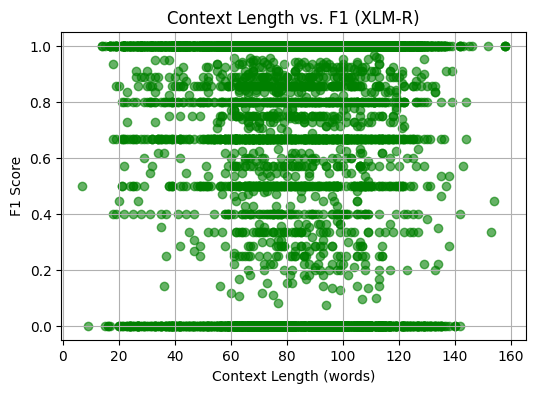

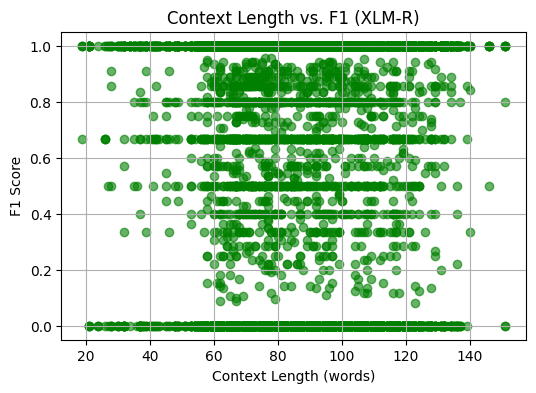

In [2]:
#!/usr/bin/env python
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import XLMRobertaForQuestionAnswering, XLMRobertaTokenizerFast

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

##############################################################################
# Minimal F1 Calculation (You can adapt from your existing scripts)
##############################################################################
def normalize_text_telugu(s):
    import re
    if not s:
        return ""
    s = re.sub(r"[^\u0C00-\u0C7Fa-zA-Z0-9\s]", "", s)
    s = s.lower()
    s = " ".join(s.split())
    return s

def f1_score(pred, gold):
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return float(pred_tokens == gold_tokens)
    precision = num_same / len(pred_tokens)
    recall    = num_same / len(gold_tokens)
    if (precision + recall) == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

##############################################################################
# Minimal Collate for Eval
##############################################################################
def squad_collate_eval(features):
    input_ids = []
    attention_masks = []
    for f in features:
        input_ids.append(torch.tensor(f["input_ids"], dtype=torch.long))
        attention_masks.append(torch.tensor(f["attention_mask"], dtype=torch.long))
    return {
        "input_ids": torch.stack(input_ids, dim=0),
        "attention_mask": torch.stack(attention_masks, dim=0)
    }

##############################################################################
# Post-processing to convert logits to string predictions
##############################################################################
def postprocess_qa_predictions_squad_v2(
    examples,
    start_logits,
    end_logits,
    cls_index=0,
    max_answer_length=30,
    n_best_size=20,
    null_score_diff_threshold=0.0
):
    def clean_prediction(text):
        import re
        if not text:
            return ""
        text = text.strip()
        text = re.sub(r"\s+", " ", text)
        return text

    preds = {}
    for i, ex in enumerate(examples):
        context = ex["context"]
        offsets = ex["offset_mapping"]
        ex_id   = ex["id"]

        # 1) Find best span
        best_score = float('-inf')
        best_start, best_end = 0, 0

        start_idxs = np.argsort(start_logits[i])[-n_best_size:].tolist()
        end_idxs   = np.argsort(end_logits[i])[-n_best_size:].tolist()

        for st in start_idxs:
            for en in end_idxs:
                if en < st:
                    continue
                if (en - st + 1) > max_answer_length:
                    continue
                if st >= len(offsets) or en >= len(offsets):
                    continue

                span_score = start_logits[i][st] + end_logits[i][en]
                if span_score > best_score:
                    best_score = span_score
                    best_start = st
                    best_end   = en

        # 2) No-answer score from [CLS]
        cls_score = start_logits[i][cls_index] + end_logits[i][cls_index]
        score_diff = best_score - cls_score
        if score_diff < null_score_diff_threshold:
            preds[ex_id] = ""
        else:
            start_char = offsets[best_start][0]
            end_char   = offsets[best_end][1]
            text_span  = context[start_char:end_char]
            preds[ex_id] = clean_prediction(text_span)
    return preds

##############################################################################
# Plotting Function: Context Length vs F1
##############################################################################
def plot_context_length_vs_f1(data_list, predictions):
    context_lengths = []
    f1_scores = []

    for ex in data_list:
        ex_id = ex["id"]
        gold_text = ex["gold_text"]
        context   = ex["context"]
        pred_text = predictions.get(ex_id, "")

        f1_val = f1_score(pred_text, gold_text)
        c_len  = len(context.split())  # word-based length

        context_lengths.append(c_len)
        f1_scores.append(f1_val)

    plt.figure(figsize=(6,4))
    plt.scatter(context_lengths, f1_scores, alpha=0.6, color="green")
    plt.title("Context Length vs. F1 (XLM-R)")
    plt.xlabel("Context Length (words)")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

##############################################################################
# Main
##############################################################################
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Adjust paths:
    DATA_DIR = "xlm_r_processed_telugu_squad_v2"

    # Adjust these paths:
    MODEL_DIR = "./final_xlmr_2.0_tel_3"
    VAL_FILE  = os.path.join(DATA_DIR, "val.pt")
    TEST_FILE = os.path.join(DATA_DIR, "test.pt")

    # Load model & tokenizer
    model = XLMRobertaForQuestionAnswering.from_pretrained(MODEL_DIR)
    model.to(device)
    model.eval()

    tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large")

    def run_eval(data_file):
        data_list = torch.load(data_file)
        dataset = Dataset.from_list(data_list)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=squad_collate_eval)

        start_all = []
        end_all   = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                start_all.append(outputs.start_logits.cpu().numpy())
                end_all.append(outputs.end_logits.cpu().numpy())

        start_all = np.concatenate(start_all, axis=0)
        end_all   = np.concatenate(end_all, axis=0)

        preds = postprocess_qa_predictions_squad_v2(data_list, start_all, end_all, cls_index=0)
        return data_list, preds

    # Evaluate on val set
    if os.path.exists(VAL_FILE):
        val_list, val_preds = run_eval(VAL_FILE)
        # Plot context length vs. F1
        plot_context_length_vs_f1(val_list, val_preds)

    # Evaluate on test set
    if os.path.exists(TEST_FILE):
        test_list, test_preds = run_eval(TEST_FILE)
        plot_context_length_vs_f1(test_list, test_preds)

if __name__ == "__main__":
    main()

### MuRiLL

In [7]:
#!/usr/bin/env python
# Muril_preprocess_squad_v2.py

import json
import os
import torch
from tqdm import tqdm
# Instead of XLMRobertaTokenizerFast:
from transformers import BertTokenizerFast  # or AutoTokenizer

###############################################
# 1) Config
###############################################
# Adjust to your SQuAD v2.0–style JSONs
train_json = "Telugu Data/squad2.0_telugu_train.json"   # SQuAD 2.0 train
val_json   = "Telugu Data/squad2.0_telugu_val.json"     # SQuAD 2.0 val
test_json  = "Telugu Data/squad2.0_telugu_test.json"    # SQuAD 2.0 test
out_dir    = "murill_processed_telugu_squad_v2"

# train_json = "English Data/squad2.0_train.json"   # SQuAD 2.0 train
# val_json   = "English Data/squad2.0_val.json"     # SQuAD 2.0 val
# test_json  = "English Data/squad2.0_test.json"    # SQuAD 2.0 test
# out_dir    = "murill_processed_english_squad_v2"

os.makedirs(out_dir, exist_ok=True)

max_length = 384
doc_stride = 128
model_tokenizer_name = "google/muril-large-cased"  # a BERT-based model

###############################################
def load_squad_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    examples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                examples.append({
                    "id": qa["id"],
                    "context": context,
                    "question": qa["question"],
                    "is_impossible": qa.get("is_impossible", False),
                    "answers": qa.get("answers", []),
                    "plausible_answers": qa.get("plausible_answers", [])
                })
    return examples

def build_items(examples, tokenizer, max_length=384, doc_stride=128):
    data_list = []
    used_stride = min(doc_stride, max_length - 17)
    if used_stride < 0:
        used_stride = 0

    for ex in tqdm(examples, desc="Processing"):
        context = ex["context"]
        question= ex["question"]
        is_imp  = ex["is_impossible"]
        gold_text = ""
        start_char, end_char = None, None
        if (not is_imp) and ex["answers"]:
            ans = ex["answers"][0]
            gold_text  = ans["text"]
            start_char = ans["answer_start"]
            end_char   = start_char + len(gold_text)

        enc = tokenizer(
            question,
            context,
            max_length=max_length,
            truncation="only_second",
            stride=used_stride,
            return_offsets_mapping=True,
            return_overflowing_tokens=True,
            padding="max_length",
            return_tensors="pt"
        )

        for i in range(len(enc["input_ids"])):
            input_ids_i      = enc["input_ids"][i]
            attention_mask_i = enc["attention_mask"][i]
            offset_mapping_i = enc["offset_mapping"][i].tolist()

            # Find [CLS] => usually token_id=101 for BERT-based
            cls_idx = (input_ids_i == tokenizer.cls_token_id).nonzero()
            if len(cls_idx)>0:
                cls_idx = cls_idx[0].item()
            else:
                cls_idx = 0

            start_idx = cls_idx
            end_idx   = cls_idx

            if (not is_imp) and gold_text and (start_char is not None) and (end_char is not None):
                found_start = None
                found_end   = None
                for j,(off_start,off_end) in enumerate(offset_mapping_i):
                    if off_start <= start_char < off_end:
                        found_start = j
                    if off_start < end_char <= off_end:
                        found_end = j
                    if (found_start is not None) and (found_end is not None):
                        break
                if (found_start is not None) and (found_end is not None) and found_end>=found_start:
                    start_idx = found_start
                    end_idx   = found_end

            item = {
                "id": ex["id"],
                "input_ids": input_ids_i,
                "attention_mask": attention_mask_i,
                "offset_mapping": offset_mapping_i,
                "start_positions": torch.tensor(start_idx, dtype=torch.long),
                "end_positions":   torch.tensor(end_idx,   dtype=torch.long),
                "context": context,
                "question": question, 
                "gold_text": gold_text
            }
            data_list.append(item)
    return data_list

def main():
    print(f"Loading MuRIL tokenizer: {model_tokenizer_name}")
    # So we avoid the mismatch error:
    tokenizer = BertTokenizerFast.from_pretrained(model_tokenizer_name)

    print("Loading train data from:", train_json)
    train_ex = load_squad_json(train_json)
    print("Loading val data from:", val_json)
    val_ex   = load_squad_json(val_json)

    test_ex  = []
    if os.path.exists(test_json):
        print("Loading test data from:", test_json)
        test_ex = load_squad_json(test_json)
    else:
        print("No test file found => skipping")

    print("\nBuilding train items...")
    train_list = build_items(train_ex, tokenizer, max_length, doc_stride)
    print("Building val items...")
    val_list   = build_items(val_ex, tokenizer, max_length, doc_stride)

    test_list = []
    if test_ex:
        print("Building test items...")
        test_list = build_items(test_ex, tokenizer, max_length, doc_stride)

    torch.save(train_list, os.path.join(out_dir, "train.pt"))
    torch.save(val_list,   os.path.join(out_dir, "val.pt"))
    if test_list:
        torch.save(test_list, os.path.join(out_dir, "test.pt"))

    print("Done! train:", len(train_list), " val:", len(val_list), " test:", len(test_list))

if __name__ == "__main__":
    main()


Loading MuRIL tokenizer: google/muril-large-cased
Loading train data from: Telugu Data/squad2.0_telugu_train.json
Loading val data from: Telugu Data/squad2.0_telugu_val.json
Loading test data from: Telugu Data/squad2.0_telugu_test.json

Building train items...


Processing: 100%|██████████| 109680/109680 [05:28<00:00, 333.63it/s]


Building val items...


Processing: 100%|██████████| 8595/8595 [00:22<00:00, 381.56it/s]


Building test items...


Processing: 100%|██████████| 10846/10846 [00:28<00:00, 377.16it/s]


Done! train: 109680  val: 8595  test: 10846


Device: cuda

Loading final MuRIL model from: ./final_muril_2.0_tel_3
Loading tokenizer from: ./final_muril_2.0_tel_3

Loading [val] data from: ./murill_processed_telugu_squad_v2/val.pt
Running inference on val set... (num_examples=8595)

[VAL SET METRICS]:
  em: 57.08
  f1: 71.84
  bleu_unigram: 49.57
  bleu_bigram: 37.35
  rouge1: 14.75
  rouge2: 1.69
  rougeL: 14.75
  is_impossible_acc: 80.80
------------------------------------------------------------

Performing error analysis on VAL set...

Error Category Counts:
  Correct: 4906
  Partial Span: 2072
  No Overlap: 718
  Unanswerable FN: 517
  Unanswerable FP: 382

Answerable vs. Unanswerable Confusion Matrix:
{'TP': 6083, 'FP': 383, 'FN': 517, 'TN': 1612}

Showing 5 Misclassified Examples:

Example ID: 56be9add3aeaaa14008c9156
Question: 2011లో, బెయోన్స్ నాలుగు రాత్రులు ఎక్కడ ప్రదర్శన ఇచ్చింది? 
Gold: న్యూయార్క్ బాల్ల్యాండ్ యొక్క న్యూయార్క్
Pred: న్యూయార్క్ బాల్ల్యాండ్
Error Type: Partial Span, F1=0.67

Example ID: 56bf8fc1a10cfb14

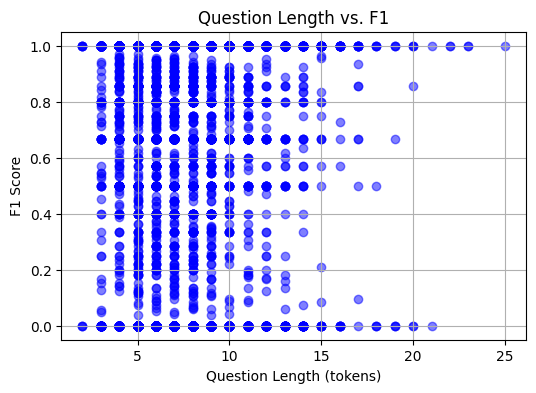

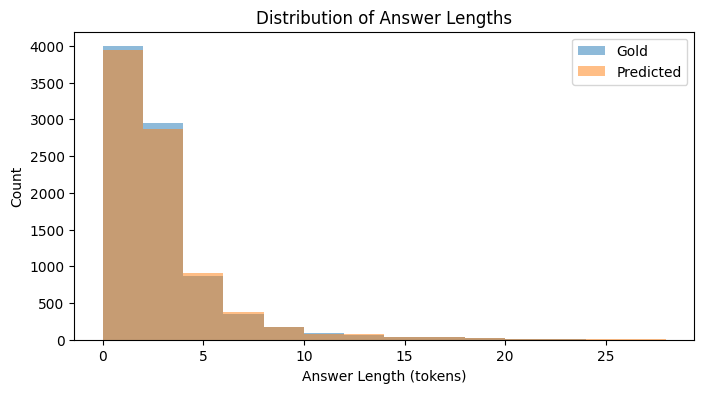


Loading [test] data from: ./murill_processed_telugu_squad_v2/test.pt
Running inference on test set... (num_examples=10846)

[TEST SET METRICS]:
  em: 58.94
  f1: 69.90
  bleu_unigram: 29.40
  bleu_bigram: 23.21
  rouge1: 8.00
  rouge2: 0.93
  rougeL: 8.00
  is_impossible_acc: 75.02
------------------------------------------------------------

Performing error analysis on TEST set...

Error Category Counts:
  Correct: 6393
  Partial Span: 1953
  Unanswerable FN: 476
  No Overlap: 671
  Unanswerable FP: 1353

Answerable vs. Unanswerable Confusion Matrix:
{'TP': 4954, 'FP': 1353, 'FN': 476, 'TN': 4063}

Showing 5 Misclassified Examples:

Example ID: 56ddde6b9a695914005b962c
Question: ఏ శతాబ్దంలో నార్మన్లు మొదట తమ ప్రత్యేక గుర్తింపును పొందారు? 
Gold: గుర్తింపు 10వ శతాబ్దం మొదటి భాగంలో
Pred: 10వ
Error Type: Partial Span, F1=0.33

Example ID: 56dddf4066d3e219004dad5f
Question: హేస్టింగ్స్ యుద్ధంలో డ్యూక్ ఎవరు? 
Gold: విలియం యొక్క బోసెన్స్
Pred: 
Error Type: Unanswerable FN, F1=0.00

Example

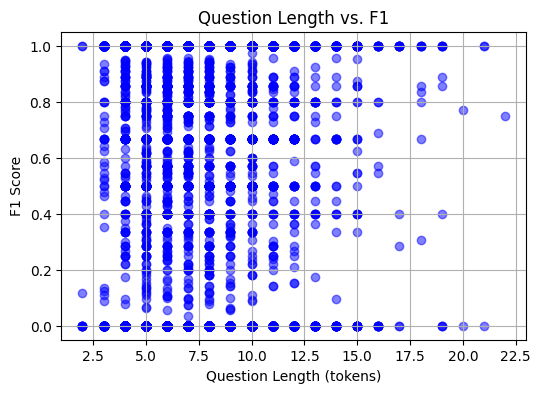

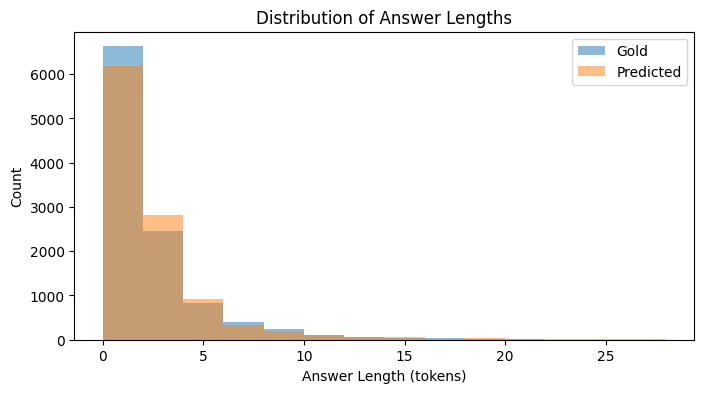


Evaluation + Error Analysis completed.


In [10]:
#!/usr/bin/env python
# eval_squad_v2_muril_with_error_analysis.py
#
# An evaluation + error analysis script for your MuRIL QA model (SQuAD v2.0 style).
# Adapts the logic from your XLM-R script but for MuRIL (BertForQuestionAnswering).

import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    BertForQuestionAnswering,
    BertTokenizerFast
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from collections import Counter

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

##############################################################################
# 1) Telugu-Specific Normalization
##############################################################################
def normalize_text_telugu(s):
    """
    Minimal Telugu-oriented normalization:
      - Removes extra punctuation
      - Lowercases any English letters
      - Strips extra whitespace
    """
    if not s:
        return ""
    # Remove everything not Telugu or alphanumeric. Adjust for your corpus if needed.
    s = re.sub(r"[^\u0C00-\u0C7Fa-zA-Z0-9\s]", "", s)
    # Lowercase (affects only English letters)
    s = s.lower()
    # Remove multiple spaces
    s = " ".join(s.split())
    return s

##############################################################################
# 2) Basic Cleaning for Predicted Spans
##############################################################################
def clean_prediction(text):
    if not text:
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

##############################################################################
# 3) No-Answer Post-processing for SQuAD v2.0
##############################################################################
def postprocess_qa_predictions_squad_v2(
    examples,
    start_logits,
    end_logits,
    cls_index=0,
    max_answer_length=100,
    n_best_size=20,
    null_score_diff_threshold=0.0
):
    """
    - examples: list of dicts with "id", "context", "offset_mapping", etc.
    - start_logits[i], end_logits[i]: arrays of shape [sequence_length].
    - cls_index: index for [CLS] token logit. For MuRIL, typically 0 in the input IDs.
    - null_score_diff_threshold: threshold for "no answer" decision.
    """
    preds = {}

    for i, ex in enumerate(examples):
        context = ex["context"]
        offsets = ex["offset_mapping"]
        ex_id   = ex["id"]

        # 1) Find best span
        best_score = float('-inf')
        best_start, best_end = 0, 0

        start_idxs = np.argsort(start_logits[i])[-n_best_size:].tolist()
        end_idxs   = np.argsort(end_logits[i])[-n_best_size:].tolist()

        for st in start_idxs:
            for en in end_idxs:
                if en < st:
                    continue
                if (en - st + 1) > max_answer_length:
                    continue
                if st >= len(offsets) or en >= len(offsets):
                    continue

                span_score = start_logits[i][st] + end_logits[i][en]
                if span_score > best_score:
                    best_score = span_score
                    best_start = st
                    best_end   = en

        # 2) Calculate no-answer score from [CLS] token
        cls_score = start_logits[i][cls_index] + end_logits[i][cls_index]

        # 3) Decide if no-answer
        score_diff = best_score - cls_score
        if score_diff < null_score_diff_threshold:
            preds[ex_id] = ""
        else:
            start_char = offsets[best_start][0]
            end_char   = offsets[best_end][1]
            text_span  = context[start_char:end_char]
            preds[ex_id] = clean_prediction(text_span)

    return preds

##############################################################################
# 4) Metrics: EM, F1, BLEU, ROUGE, plus is_impossible accuracy
##############################################################################
def exact_match(pred, gold):
    return 1.0 if normalize_text_telugu(pred) == normalize_text_telugu(gold) else 0.0

def f1_score(pred, gold):
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return float(pred_tokens == gold_tokens)
    precision = num_same / len(pred_tokens)
    recall    = num_same / len(gold_tokens)
    if (precision + recall) == 0:
        return 0.0
    return (2.0 * precision * recall) / (precision + recall)

def compute_bleu(pred, gold):
    if not pred or not gold:
        return {"unigram": 0.0, "bigram": 0.0}
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    smoothing = SmoothingFunction().method1
    unigram = sentence_bleu([gold_tokens], pred_tokens,
                            weights=(1, 0, 0, 0),
                            smoothing_function=smoothing)
    bigram  = sentence_bleu([gold_tokens], pred_tokens,
                            weights=(0.5, 0.5, 0, 0),
                            smoothing_function=smoothing)
    return {"unigram": unigram, "bigram": bigram}

def compute_rouge(pred, gold):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=False)
    if not pred or not gold:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    pred_clean = normalize_text_telugu(pred)
    gold_clean = normalize_text_telugu(gold)
    scores = scorer.score(pred_clean, gold_clean)
    return {
        "rouge1": scores["rouge1"].fmeasure,
        "rouge2": scores["rouge2"].fmeasure,
        "rougeL": scores["rougeL"].fmeasure
    }

def compute_is_impossible_accuracy(examples, predictions):
    """
    For each example, if gold_text is empty => gold is_impossible.
    Check if predicted text is also empty => predicted is_impossible.
    Then compute accuracy over *only* the is_impossible subset.
    """
    total_impossible = 0
    correct_impossible = 0
    for ex in examples:
        gold = ex.get("gold_text", "")
        gold_impossible = (gold.strip() == "")
        if gold_impossible:
            total_impossible += 1
            pred_text = predictions.get(ex["id"], "")
            if pred_text.strip() == "":
                correct_impossible += 1

    if total_impossible == 0:
        return 100.0  # or 0.0, depending on preference
    return (correct_impossible / total_impossible) * 100.0

##############################################################################
# 5) Master Evaluation Function
##############################################################################
def evaluate_squad_v2(examples, start_logits, end_logits, null_score_diff_threshold=0.0):
    """
    Returns a dict with EM, F1, BLEU, ROUGE, plus 'is_impossible_acc'.
    Also returns the raw predictions for error analysis.
    """
    predictions = postprocess_qa_predictions_squad_v2(
        examples,
        start_logits,
        end_logits,
        cls_index=0,  # For MuRIL, position 0 is typically [CLS]
        null_score_diff_threshold=null_score_diff_threshold
    )

    total = len(examples)
    metrics = {
        "em": 0.0,
        "f1": 0.0,
        "bleu_unigram": 0.0,
        "bleu_bigram": 0.0,
        "rouge1": 0.0,
        "rouge2": 0.0,
        "rougeL": 0.0
    }

    for ex in examples:
        gold = ex.get("gold_text", "")
        pred = predictions.get(ex["id"], "")

        metrics["em"] += exact_match(pred, gold)
        metrics["f1"] += f1_score(pred, gold)

        bleu_scores = compute_bleu(pred, gold)
        metrics["bleu_unigram"] += bleu_scores["unigram"]
        metrics["bleu_bigram"]  += bleu_scores["bigram"]

        rouge_scores = compute_rouge(pred, gold)
        metrics["rouge1"] += rouge_scores["rouge1"]
        metrics["rouge2"] += rouge_scores["rouge2"]
        metrics["rougeL"] += rouge_scores["rougeL"]

    # Average the main metrics
    for key in metrics:
        metrics[key] = (metrics[key] / total) * 100.0

    # Calculate is_impossible accuracy
    is_imp_acc = compute_is_impossible_accuracy(examples, predictions)
    metrics["is_impossible_acc"] = is_imp_acc

    return metrics, predictions

##############################################################################
# 6) Minimal Collate for Eval
##############################################################################
def squad_collate_eval(features):
    """
    For evaluation, we only need input_ids & attention_mask for the model.
    Convert lists to Tensors.
    """
    input_ids = []
    attention_masks = []
    for f in features:
        input_ids.append(torch.tensor(f["input_ids"], dtype=torch.long))
        attention_masks.append(torch.tensor(f["attention_mask"], dtype=torch.long))
    return {
        "input_ids": torch.stack(input_ids, dim=0),
        "attention_mask": torch.stack(attention_masks, dim=0)
    }

##############################################################################
# 7) Error Analysis: Categorizing and Visualization
##############################################################################
def categorize_errors(example, pred_text):
    """
    Returns a string category label for the error type:
      - "Correct" if EM = 1.0
      - "Partial Span" if F1 > 0 but < 1
      - "Unanswerable FP" if gold is empty but prediction is not
      - "Unanswerable FN" if gold is not empty but prediction is empty
      - "No Overlap" if F1 == 0 (and not unanswerable mismatch)
      - "Other" fallback
    """
    gold_text = example.get("gold_text", "")
    pred_text = pred_text.strip()
    em_val = exact_match(pred_text, gold_text)
    f1_val = f1_score(pred_text, gold_text)

    gold_empty = (gold_text.strip() == "")
    pred_empty = (pred_text == "")

    if em_val == 1.0:
        return "Correct"
    if gold_empty and not pred_empty:
        return "Unanswerable FP"
    if not gold_empty and pred_empty:
        return "Unanswerable FN"
    if f1_val > 0 and f1_val < 1.0:
        return "Partial Span"
    if f1_val == 0:
        return "No Overlap"
    return "Other"

def build_confusion_matrix_answerable(df):
    """
    Builds a confusion matrix specifically for answerable vs. unanswerable.
    We'll define:
        gold_answerable = gold_text != ""
        pred_answerable = pred_text != ""
    Returns a dict with {TP, FP, FN, TN}.
    """
    tp = fp = fn = tn = 0
    for _, row in df.iterrows():
        gold_is_ans = (row["gold_text"].strip() != "")
        pred_is_ans = (row["pred_text"].strip() != "")

        if gold_is_ans and pred_is_ans:
            tp += 1
        elif not gold_is_ans and pred_is_ans:
            fp += 1
        elif gold_is_ans and not pred_is_ans:
            fn += 1
        else:
            tn += 1

    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn}

def perform_error_analysis(data_list, predictions, do_plots=True, show_samples=5):
    """
    - data_list: list of examples with keys ["id", "question", "gold_text", "context", ...]
    - predictions: dict of {example_id: predicted_text}
    - do_plots: if True, generates some example plots
    - show_samples: how many misclassified examples to print

    Returns a DataFrame for further manual analysis.
    """
    rows = []
    for ex in data_list:
        ex_id  = ex["id"]
        gold   = ex.get("gold_text", "")
        q_text = ex.get("question", "")
        ctx    = ex.get("context", "")
        pred   = predictions.get(ex_id, "")

        em_val  = exact_match(pred, gold)
        f1_val  = f1_score(pred, gold)
        e_type  = categorize_errors(ex, pred)

        rows.append({
            "id": ex_id,
            "question": q_text,
            "gold_text": gold,
            "pred_text": pred,
            "f1": f1_val,
            "em": em_val,
            "error_type": e_type,
            "context": ctx
        })

    df = pd.DataFrame(rows)

    # Count of each error category
    error_counts = Counter(df["error_type"])
    print("\nError Category Counts:")
    for k, v in error_counts.items():
        print(f"  {k}: {v}")

    # Confusion Matrix for answerable vs unanswerable
    cm = build_confusion_matrix_answerable(df)
    print("\nAnswerable vs. Unanswerable Confusion Matrix:")
    print(cm)

    # Show sample misclassified examples
    misclassified_df = df[df["error_type"] != "Correct"]
    if show_samples > 0 and len(misclassified_df) > 0:
        print(f"\nShowing {min(show_samples, len(misclassified_df))} Misclassified Examples:")
        for i in range(min(show_samples, len(misclassified_df))):
            row = misclassified_df.iloc[i]
            print(f"\nExample ID: {row['id']}")
            print(f"Question: {row['question']}")
            print(f"Gold: {row['gold_text']}")
            print(f"Pred: {row['pred_text']}")
            print(f"Error Type: {row['error_type']}, F1={row['f1']:.2f}")

    # Plot distributions if requested
    if do_plots:
        # 1) Question Length vs. F1
        df["q_len"] = df["question"].apply(lambda x: len(x.split()))
        plt.figure(figsize=(6,4))
        plt.scatter(df["q_len"], df["f1"], alpha=0.5, color="blue")
        plt.title("Question Length vs. F1")
        plt.xlabel("Question Length (tokens)")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.show()

        # 2) Distribution of Gold vs. Predicted Answer Length
        df["gold_len"] = df["gold_text"].apply(lambda x: len(normalize_text_telugu(x).split()))
        df["pred_len"] = df["pred_text"].apply(lambda x: len(normalize_text_telugu(x).split()))

        plt.figure(figsize=(8,4))
        plt.hist(df["gold_len"], bins=range(0, 30, 2), alpha=0.5, label="Gold")
        plt.hist(df["pred_len"], bins=range(0, 30, 2), alpha=0.5, label="Predicted")
        plt.title("Distribution of Answer Lengths")
        plt.xlabel("Answer Length (tokens)")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

    return df

##############################################################################
# 8) Main Evaluation + Error Analysis
##############################################################################
def main():
    # Adjust these paths for your environment:
    MODEL_DIR = "./final_muril_2.0_tel_3"
    DATA_DIR  = "./murill_processed_telugu_squad_v2"

    VAL_FILE  = os.path.join(DATA_DIR, "val.pt")
    TEST_FILE = os.path.join(DATA_DIR, "test.pt")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Load model
    print("\nLoading final MuRIL model from:", MODEL_DIR)
    model = BertForQuestionAnswering.from_pretrained(MODEL_DIR)
    model.eval()
    model.to(device)

    # Load tokenizer (optional if you need it for debugging or extra steps)
    print("Loading tokenizer from:", MODEL_DIR)
    tokenizer = BertTokenizerFast.from_pretrained(MODEL_DIR)

    def run_eval(data_file, split_name="val"):
        if not os.path.exists(data_file):
            print(f"[{split_name}] file not found: {data_file}")
            # Return THREE 'None' values
            return None, None, None

        print(f"\nLoading [{split_name}] data from:", data_file)
        data_list = torch.load(data_file)
        dataset = Dataset.from_list(data_list)

        dataloader = DataLoader(
            dataset,
            batch_size=16,
            shuffle=False,
            collate_fn=squad_collate_eval
        )

        all_start_logits = []
        all_end_logits   = []

        print(f"Running inference on {split_name} set... (num_examples={len(dataset)})")
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                start_log = outputs.start_logits.detach().cpu().numpy()
                end_log   = outputs.end_logits.detach().cpu().numpy()

                all_start_logits.append(start_log)
                all_end_logits.append(end_log)

        all_start_logits = np.concatenate(all_start_logits, axis=0)
        all_end_logits   = np.concatenate(all_end_logits, axis=0)

        # Evaluate
        results, preds = evaluate_squad_v2(
            data_list,
            all_start_logits,
            all_end_logits,
            null_score_diff_threshold=0.0
        )
        print(f"\n[{split_name.upper()} SET METRICS]:")
        for k, v in results.items():
            print(f"  {k}: {v:.2f}")
        print("-" * 60)

        # Return all three items
        return (results, data_list, preds)

    # 1) Evaluate on Validation
    val_result = run_eval(VAL_FILE, split_name="val")
    if val_result is not None:
        val_metrics, val_list, val_preds = val_result
        # Perform error analysis on validation data
        print("\nPerforming error analysis on VAL set...")
        df_val_errors = perform_error_analysis(val_list, val_preds, do_plots=True, show_samples=5)

    # 2) Evaluate on Test
    test_result = run_eval(TEST_FILE, split_name="test")
    if test_result is not None:
        test_metrics, test_list, test_preds = test_result
        # Perform error analysis on test data
        print("\nPerforming error analysis on TEST set...")
        df_test_errors = perform_error_analysis(test_list, test_preds, do_plots=True, show_samples=5)

    print("\nEvaluation + Error Analysis completed.")

if __name__ == "__main__":
    main()

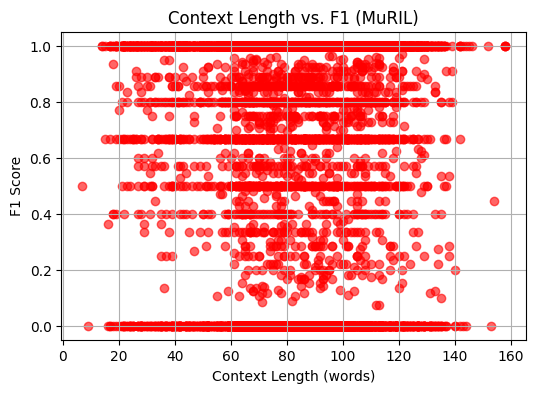

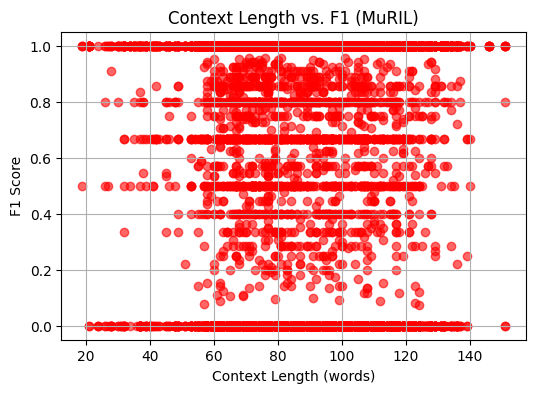

In [11]:
#!/usr/bin/env python
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import BertForQuestionAnswering, BertTokenizerFast

def normalize_text_telugu(s):
    import re
    if not s:
        return ""
    s = re.sub(r"[^\u0C00-\u0C7Fa-zA-Z0-9\s]", "", s)
    s = s.lower()
    s = " ".join(s.split())
    return s

def f1_score(pred, gold):
    pred_tokens = normalize_text_telugu(pred).split()
    gold_tokens = normalize_text_telugu(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return float(pred_tokens == gold_tokens)
    precision = num_same / len(pred_tokens)
    recall    = num_same / len(gold_tokens)
    if (precision + recall) == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def squad_collate_eval(features):
    input_ids = []
    attention_masks = []
    for f in features:
        input_ids.append(torch.tensor(f["input_ids"], dtype=torch.long))
        attention_masks.append(torch.tensor(f["attention_mask"], dtype=torch.long))
    return {
        "input_ids": torch.stack(input_ids, dim=0),
        "attention_mask": torch.stack(attention_masks, dim=0)
    }

def postprocess_qa_predictions_squad_v2(
    examples,
    start_logits,
    end_logits,
    cls_index=0,
    max_answer_length=30,
    n_best_size=20,
    null_score_diff_threshold=0.0
):
    import re
    def clean_prediction(text):
        if not text:
            return ""
        text = text.strip()
        text = re.sub(r"\s+", " ", text)
        return text

    preds = {}
    for i, ex in enumerate(examples):
        context = ex["context"]
        offsets = ex["offset_mapping"]
        ex_id   = ex["id"]

        best_score = float('-inf')
        best_start, best_end = 0, 0

        start_idxs = np.argsort(start_logits[i])[-n_best_size:].tolist()
        end_idxs   = np.argsort(end_logits[i])[-n_best_size:].tolist()

        for st in start_idxs:
            for en in end_idxs:
                if en < st:
                    continue
                if (en - st + 1) > max_answer_length:
                    continue
                if st >= len(offsets) or en >= len(offsets):
                    continue

                span_score = start_logits[i][st] + end_logits[i][en]
                if span_score > best_score:
                    best_score = span_score
                    best_start = st
                    best_end   = en

        cls_score = start_logits[i][cls_index] + end_logits[i][cls_index]
        score_diff = best_score - cls_score
        if score_diff < null_score_diff_threshold:
            preds[ex_id] = ""
        else:
            start_char = offsets[best_start][0]
            end_char   = offsets[best_end][1]
            text_span  = context[start_char:end_char]
            preds[ex_id] = clean_prediction(text_span)
    return preds

def plot_context_length_vs_f1(data_list, predictions):
    context_lengths = []
    f1_scores = []

    for ex in data_list:
        ex_id = ex["id"]
        gold_text = ex["gold_text"]
        context   = ex["context"]
        pred_text = predictions.get(ex_id, "")

        f1_val = f1_score(pred_text, gold_text)
        c_len  = len(context.split())

        context_lengths.append(c_len)
        f1_scores.append(f1_val)

    plt.figure(figsize=(6,4))
    plt.scatter(context_lengths, f1_scores, alpha=0.6, color="red")
    plt.title("Context Length vs. F1 (MuRIL)")
    plt.xlabel("Context Length (words)")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    MODEL_DIR = "./final_muril_2.0_tel_3"
    DATA_DIR  = "./murill_processed_telugu_squad_v2"

    VAL_FILE  = os.path.join(DATA_DIR, "val.pt")
    TEST_FILE = os.path.join(DATA_DIR, "test.pt")

    model = BertForQuestionAnswering.from_pretrained(MODEL_DIR)
    model.to(device)
    model.eval()

    tokenizer = BertTokenizerFast.from_pretrained(MODEL_DIR)

    def run_eval(data_file):
        data_list = torch.load(data_file)
        dataset = Dataset.from_list(data_list)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=squad_collate_eval)

        start_all = []
        end_all   = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                start_all.append(outputs.start_logits.cpu().numpy())
                end_all.append(outputs.end_logits.cpu().numpy())

        start_all = np.concatenate(start_all, axis=0)
        end_all   = np.concatenate(end_all, axis=0)

        preds = postprocess_qa_predictions_squad_v2(data_list, start_all, end_all, cls_index=0)
        return data_list, preds

    # Evaluate on val
    if os.path.exists(VAL_FILE):
        val_list, val_preds = run_eval(VAL_FILE)
        plot_context_length_vs_f1(val_list, val_preds)

    # Evaluate on test
    if os.path.exists(TEST_FILE):
        test_list, test_preds = run_eval(TEST_FILE)
        plot_context_length_vs_f1(test_list, test_preds)

if __name__ == "__main__":
    main()